# Developmental EEG Data 

This notebook analyzes a large dataset of EEG, collected from a developmental sample.

## Dataset Details

This analysis uses the 
[MIPDB dataset](http://fcon_1000.projects.nitrc.org/indi/cmi_eeg/) from the 
[ChildMind Institute](https://childmind.org/).

Note that the pre-processing of the data as available in the dataset, doing data cleaning and calculating power spectra, is done external to this project.

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from fooof import FOOOF
from fooof.utils import trim_spectrum

from neurodsp.utils import create_times
from neurodsp.spectral import compute_spectrum
from neurodsp.plts import plot_time_series, plot_power_spectra

/var/folders/59/8y2d5r257c77vzymnqs47x080000gn/T/ipykernel_65521/3142296954.py:6: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [2]:
# Import custom code
import sys
sys.path.append(str(Path('..').resolve()))

from apm.io import APMDB
from apm.run import run_measures, run_group_measures
from apm.analysis import (compute_avgs, compute_all_corrs, compute_corrs_to_feature,
                          compute_diffs_to_feature, unpack_corrs)
from apm.plts import plot_dots
from apm.plts.utils import make_axes
from apm.methods import specparam, irasa, dfa, hurst, hjorth_complexity, lempelziv, app_entropy
from apm.methods.periodic import alpha_power
from apm.utils import format_corr

In [3]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [4]:
# Data path
data_path = Path('/Users/tom/Data/VoytekLab/ExtractedSubsets/childmind/')

In [5]:
# Define data information
fs = 500
n_seconds = 30

In [6]:
# Define times vector for data
times = create_times(n_seconds + 1/fs, fs)

In [7]:
# Add plot kwargs
dot_kwargs = {
    's' : 24,
    'alpha' : 0.7,
}

In [8]:
# Settings for saving figures
SAVE_FIG = True
EXT = '.pdf'
FIGPATH = APMDB().figs_path / '42_dev_data'

## Load Data

In [9]:
# Load data files
ages = np.load(data_path / 'ages.npy')
data = np.load(data_path / 'data.npy')

In [10]:
# Check the number of subjects
n_subjs = data.shape[0]
assert n_subjs == len(ages)
print('Number of subjects: {}'.format(n_subjs))

Number of subjects: 111


## Data Checks

In [11]:
ind = 0

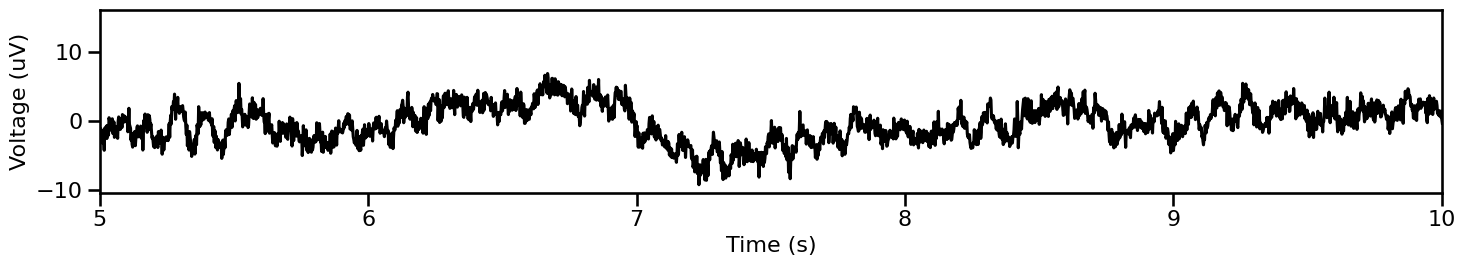

In [12]:
# Plot a segment of time series data
plot_time_series(times, data[ind, :], xlim=[5, 10])

In [13]:
# Compute a power spectrum of an example
freqs, powers = compute_spectrum(data[ind, :], fs, nperseg=2*fs, noverlap=fs)

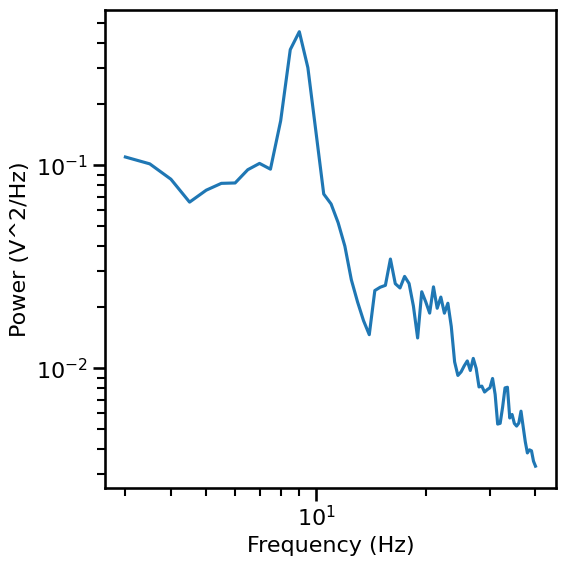

In [14]:
plot_power_spectra(*trim_spectrum(freqs, powers, [3, 40]))

## Compare Methods

This is a replication of the analysis in the initial EEG dataset. 

In [15]:
# Initialize specparam model
fm = FOOOF(verbose=False)

In [16]:
# General method settings
f_range = [3, 40]

In [17]:
# Define measures to apply
measures = {
    specparam : {'fs' : fs, 'f_range' : f_range},
    irasa : {'fs' : fs, 'f_range' : f_range},
    hurst : {'fs' : fs},
    dfa : {'fs' : fs},
    lempelziv : {},
    hjorth_complexity : {},
    app_entropy : {}
}

In [18]:
# # Compute measures of interest on the data
# results = run_measures(data, measures)

In [19]:
# # Compute correlations across all pairs of methods
# all_corrs = compute_all_corrs(results)

## Compare Measures

#### Compare Exponent Measures

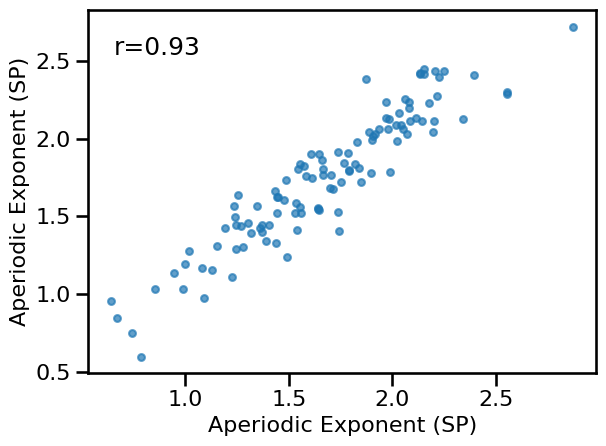

In [20]:
# Plot the comparison of specparam and IRASA exponent estimations
plot_dots(results['specparam'], results['irasa'], **dot_kwargs, tposition='tl',
          xlabel='Aperiodic Exponent (SP)', ylabel='Aperiodic Exponent (SP)',
          save_fig=SAVE_FIG, file_name='mipdb_exp_exp_comp' + EXT, file_path=FIGPATH)

In [21]:
# Check correlation between specparam and irasa exponent estimates
print('  SP-EXP & IR-EXP:  ', format_corr(*all_corrs['specparam']['irasa']))

  SP-EXP & IR-EXP:   r=+0.932  CI[+0.895, +0.953],  p=0.000


#### Compare exponent to LZ Complexity

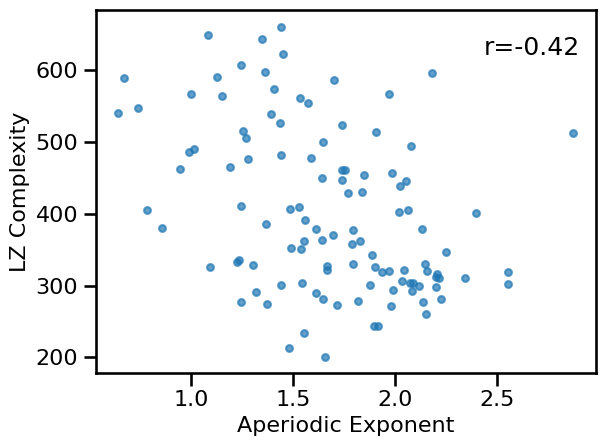

In [22]:
# Plot the comparison of specparam and lempel-ziv complexity
plot_dots(results['specparam'], results['lempelziv'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='LZ Complexity',
          save_fig=SAVE_FIG, file_name='mipdb_exp_lz_comp' + EXT, file_path=FIGPATH)

In [23]:
# Check correlation between exponent measures and Lempel-Ziv complexity estimates
print('  SP-EXP & LZC:  ', format_corr(*all_corrs['specparam']['lempelziv']))
print('  IR-EXP & LZC:  ', format_corr(*all_corrs['irasa']['lempelziv']))

  SP-EXP & LZC:   r=-0.422  CI[-0.565, -0.255],  p=0.000
  IR-EXP & LZC:   r=-0.409  CI[-0.562, -0.247],  p=0.000


#### Compare exponent to Entropy

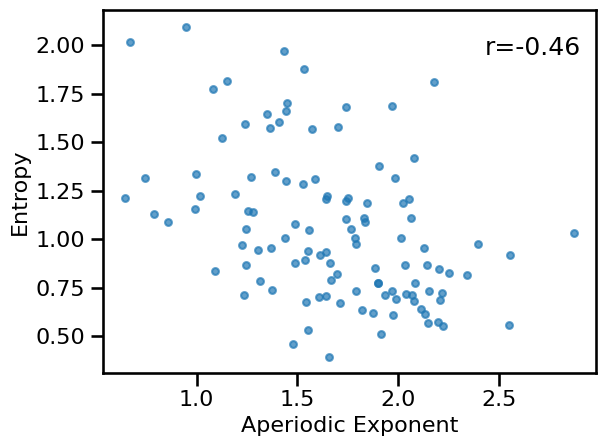

In [24]:
# Plot the comparison of specparam and approximate entropy
plot_dots(results['specparam'], results['app_entropy'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='Entropy',
          save_fig=SAVE_FIG, file_name='mipdb_exp_ent_comp' + EXT, file_path=FIGPATH)

In [25]:
# Check correlation between exponent measures and entropy estimates
print('  SP-EXP & ENT:  ', format_corr(*all_corrs['specparam']['app_entropy']))
print('  IR-EXP & ENT:  ', format_corr(*all_corrs['irasa']['app_entropy']))

  SP-EXP & ENT:   r=-0.463  CI[-0.592, -0.306],  p=0.000
  IR-EXP & ENT:   r=-0.467  CI[-0.592, -0.315],  p=0.000


## Check Alpha Relationship

In [40]:
# Define periodic measures to compute
peak_measures = {alpha_power : measures[specparam]}

In [41]:
# Compute periodic measures
peak_results = run_measures(data, peak_measures)

In [28]:
# Compute correlations between aperiodic measures and alpha power
alpha_corrs = compute_corrs_to_feature(results, peak_results['alpha_power'])

In [29]:
# Compute differences between correlations between aperiodic measures and alpha power
alpha_corr_diffs = compute_diffs_to_feature(results, peak_results['alpha_power'])

In [30]:
# Check the correlations between alpha power and aperiodic measures
print('Correlations with alpha:')
for label in alpha_corrs.keys():
    print('     {:20s}:  '.format(label), format_corr(*alpha_corrs[label]))

Correlations with alpha:
     specparam           :   r=+0.319  CI[+0.138, +0.484],  p=0.001
     irasa               :   r=+0.450  CI[+0.283, +0.592],  p=0.000
     hurst               :   r=-0.596  CI[-0.701, -0.457],  p=0.000
     dfa                 :   r=-0.014  CI[-0.200, +0.176],  p=0.886
     lempelziv           :   r=-0.250  CI[-0.422, -0.076],  p=0.008
     hjorth_complexity   :   r=+0.271  CI[+0.093, +0.432],  p=0.004
     app_entropy         :   r=-0.357  CI[-0.509, -0.191],  p=0.000


## Check Age Relationship

In [31]:
# Compute the correlations between each measure and age
age_corrs = compute_corrs_to_feature(results, ages)

In [32]:
# Compute the differences between measure-to-age correlations
age_corr_diffs = compute_diffs_to_feature(results, ages)

#### Check Correlations with Age

In [33]:
# Check the correlations between alpha power and aperiodic measures
print('Correlations with age:')
for label in age_corrs.keys():
    print('     {:20s}:  '.format(label), format_corr(*age_corrs[label]))

Correlations with age:
     specparam           :   r=-0.502  CI[-0.626, -0.361],  p=0.000
     irasa               :   r=-0.469  CI[-0.602, -0.316],  p=0.000
     hurst               :   r=+0.426  CI[+0.259, +0.561],  p=0.000
     dfa                 :   r=-0.335  CI[-0.490, -0.163],  p=0.000
     lempelziv           :   r=+0.213  CI[+0.026, +0.382],  p=0.025
     hjorth_complexity   :   r=-0.218  CI[-0.398, -0.029],  p=0.021
     app_entropy         :   r=+0.260  CI[+0.081, +0.430],  p=0.006


#### Plot age relationships

In [34]:
sns.set_context('paper')

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


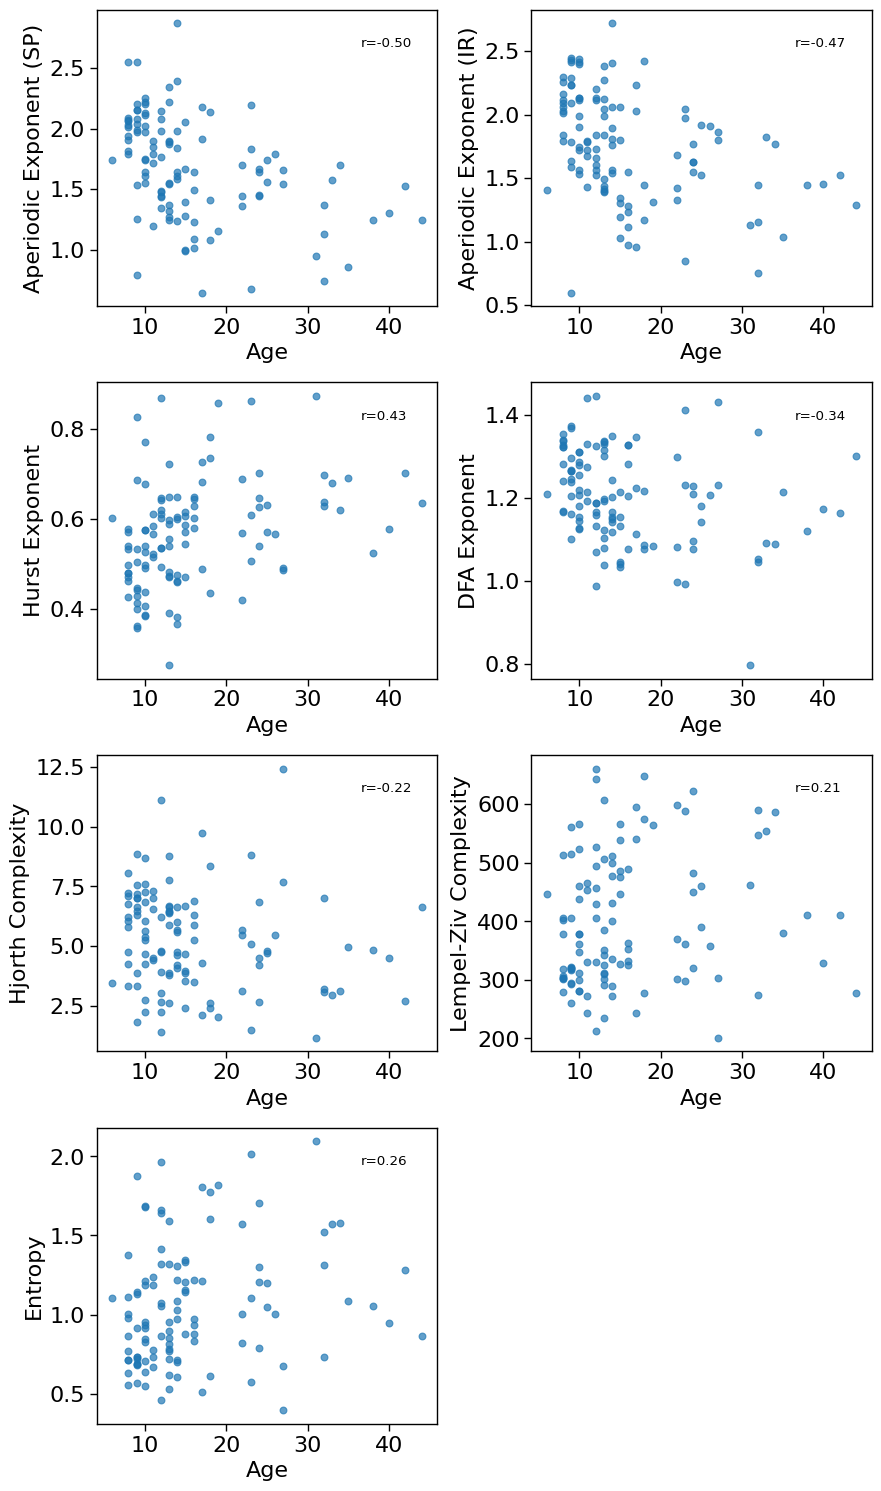

In [35]:
# Check the relationship between aperiodic exponent and age
axes = make_axes(4, 2, figsize=(9, 15), wspace=0.25, hspace=0.25)
plot_dots(ages, results['specparam'], **dot_kwargs, ax=axes[0, 0],
          xlabel='Age', ylabel='Aperiodic Exponent (SP)')
plot_dots(ages, results['irasa'], **dot_kwargs, ax=axes[0, 1],
          xlabel='Age', ylabel='Aperiodic Exponent (IR)')
plot_dots(ages, results['hurst'], **dot_kwargs, ax=axes[1, 0],
          xlabel='Age', ylabel='Hurst Exponent')
plot_dots(ages, results['dfa'], **dot_kwargs, ax=axes[1, 1],
          xlabel='Age', ylabel='DFA Exponent')
plot_dots(ages, results['hjorth_complexity'], **dot_kwargs, ax=axes[2, 0],
          xlabel='Age', ylabel='Hjorth Complexity')
plot_dots(ages, results['lempelziv'], **dot_kwargs, ax=axes[2, 1],
          xlabel='Age', ylabel='Lempel-Ziv Complexity')
plot_dots(ages, results['app_entropy'], **dot_kwargs, ax=axes[3, 0],
          xlabel='Age', ylabel='Entropy')
axes[3, 1].axis('off');
if SAVE_FIG: plt.savefig(FIGPATH / ('mipdb_age' + EXT))

## Topographies

In [20]:
import csv

import numpy as np
from matplotlib import cm

import mne
from mne.viz import plot_topomap

In [21]:
path = Path('/Users/tom/Desktop/apm_data/')

In [22]:
group_data = np.load(path / 'MIPDB_extracted_block.npy')
group_data = np.squeeze(group_data[:, 0, :, :])

In [24]:
FS = 500

In [26]:
group_results = run_group_measures(group_data[0:5, :, :], measures)

In [27]:
group_avg = compute_avgs(group_results)

In [28]:
# Read in list of channel names that are kept in reduced 111 montage
with open(path / 'chans111.csv', 'r') as csv_file:
    reader = csv.reader(csv_file)
    ch_labels = list(reader)[0]

In [29]:
montage = mne.channels.make_standard_montage('GSN-HydroCel-129')
info = mne.create_info(ch_labels, FS, 'eeg')
info = info.set_montage(montage)

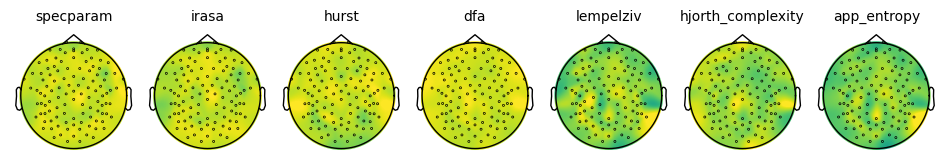

In [30]:
axes = make_axes(1, 7, figsize=(12, 3), wspace=0.05)
for measure, ax in zip(group_avg, axes):
    ax.set_title(measure, fontdict={'fontsize' : 10})
    plot_topomap(group_avg[measure], info, cmap=cm.viridis, contours=0, size=2, axes=ax, show=False)

In [31]:
group_corrs = compute_all_corrs(group_avg)

In [32]:
group_corrs_mat = unpack_corrs(group_corrs)

In [36]:
mask = np.triu(group_corrs_mat)
labels = list(group_corrs.keys())

<Axes: >

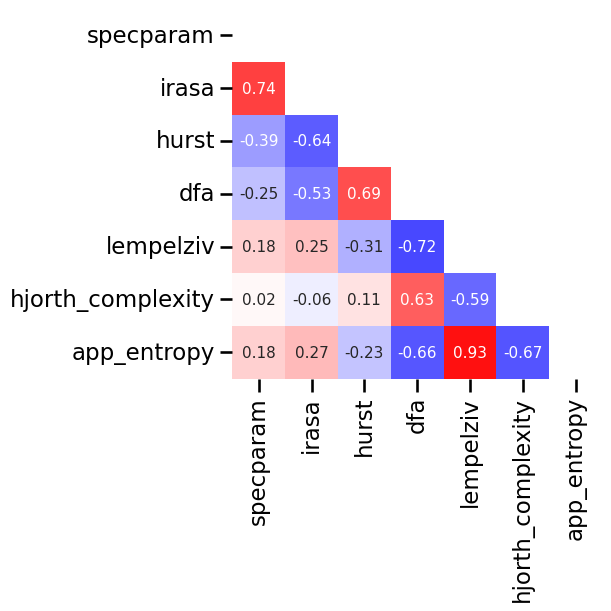

In [37]:
sns.heatmap(group_corrs_mat, cmap="bwr", annot=True, fmt='1.2f', cbar=False, square=True,
            vmin=-1, vmax=1, annot_kws={"size": 11}, mask=mask,
            xticklabels=labels, yticklabels=labels)#, ax=ax1);

In [46]:
group_results_peaks = run_group_measures(group_data[0:5], peak_measures)

In [47]:
group_results_peaks['alpha_power'] = np.log10(group_results_peaks['alpha_power'])

In [48]:
group_avg_peaks = compute_avgs(group_results_peaks)

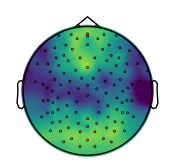

(<matplotlib.image.AxesImage at 0x7fc47d7b8e20>, None)

In [52]:
plot_topomap(group_avg_peaks['alpha_power'], info, cmap=cm.viridis,
             contours=0, size=2)#, vlim=(-11.5, -10.5))

In [50]:
# Compute correlations between aperiodic measures and alpha power
group_alpha_corrs = compute_corrs_to_feature(group_avg, group_avg_peaks['alpha_power'])

In [51]:
# Compute differences between correlations between aperiodic measures and alpha power
group_alpha_corr_diffs = compute_diffs_to_feature(group_avg, group_avg_peaks['alpha_power'])

## Conclusions

Interim conclusions from this analysis:
- specparam & IRASA estimates are consistent in this dataset
- aperiodic exponent is moderately correlated with time domain measures

Notably, these findings are a replication of the same analyses on the previous EEG dataset.

In addition, in this larger dataset, we could analyze the relationship between our measures of interest, and age, finding that:
- specparam & IRASA estimates of exponent are equivalently correlated with age
- time domain measures are more moderately correlated with age than exponent measures